<a href="https://colab.research.google.com/github/cutlersimpson/GU-ML/blob/main/Brain_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The GEO link for the data used in this analysis can be found [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE50161). The original data was curated and formatted into a CSV file by the [SBCB Lab](https://sbcb.inf.ufrgs.br/cumida) who reported a Random Forest Model accuracy of 91% in their investigation. The CSV file provided by the SBCB Lab was hosted on Harvard Dataverse and can be found [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/RILXEA). The publication associated with the data originally collected samples belonging to 5 groups (7 pilocytic astrocytoma (PA), 19 ependymoma (EPN), 5 glioblastoma (GBM), 6
medulloblastoma (MED) and 5 non-tumor brain (NT)) from pediatric epilepsy surgical patients and continued to collect more samples. The original authors sought to identify different immunophenotypes for each brain cancer subtype in the hopes of laying the ground work to identify specific immunotherapies for each cancer type. My goal is to analyze this data and determine if cancer samples can be distinguished from healthy controls and, if so, what significant features allow this.

# Dependency Installation
---

In [1]:
!pip install lazypredict -q

In [2]:
#import pandas and numpy
import pandas as pd
import numpy as np

#PCA
from sklearn.decomposition import PCA 

#import standard classification tools from sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 
import itertools

#classification model
from sklearn.model_selection import train_test_split

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

#Autoencoder
import sys
import csv
from keras.layers import Dense,Input,Dropout
from keras.models import Model
from sklearn.neural_network import MLPClassifier as ANN

#Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch

#Lazy predict
import time 
from lazypredict.Supervised import LazyClassifier,LazyRegressor
import collections

#Tree visualization
from IPython.display import Image
from sklearn.tree import export_graphviz
from subprocess import call

template = 'ggplot2'

# Data Loading and Preprocessing
---

In [3]:
# Load data, because this is a large file do this separately to avoid repetition
original_data = pd.read_csv('/content/Brain_GSE50161.csv')

In [4]:
# Drop samples column and randomly preview data

data = original_data.drop(['samples'], axis=1)
data.sample(n = 5)

,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
85,medulloblastoma,11.34,9.21,6.22,8.29,4.51,7.51,7.83,5.64,5.07,...,13.37,12.98,14.24,14.12,5.17,4.61,3.69,3.80,4.65,4.52
57,glioblastoma,12.42,8.18,7.24,9.39,4.19,6.90,6.25,5.92,5.81,...,12.76,12.55,13.30,13.46,5.23,4.69,3.98,3.55,4.47,4.55
122,pilocytic_astrocytoma,13.02,8.87,7.57,8.49,6.44,8.98,6.87,5.99,5.35,...,12.41,11.73,13.83,13.61,5.25,4.90,4.09,4.24,4.75,4.55
32,ependymoma,12.16,7.72,7.34,9.39,4.21,7.53,6.00,6.63,6.40,...,10.51,10.39,12.93,12.93,5.23,4.81,4.01,3.72,4.72,4.74
119,pilocytic_astrocytoma,12.45,7.69,7.11,9.65,4.67,8.12,6.24,6.41,7.11,...,10.31,10.26,12.81,12.91,5.27,4.72,3.94,3.64,4.48,4.71


In [5]:
# Split data into labels and numeric values

X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

features = data.columns[1:]
samples = original_data['samples']

classes = np.unique(y)
n_classes = len(classes)

data.type.value_counts()

ependymoma               46
glioblastoma             34
medulloblastoma          22
pilocytic_astrocytoma    15
normal                   13
Name: type, dtype: int64

In [6]:
scaled = StandardScaler() 
scaled.fit(X) 
scaled_data = scaled.transform(X)

# Data Exploration
---

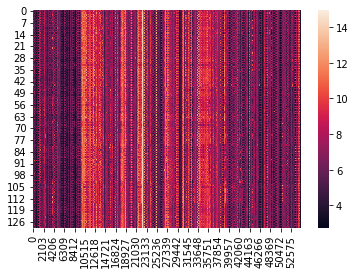

In [7]:
sns.heatmap(X)

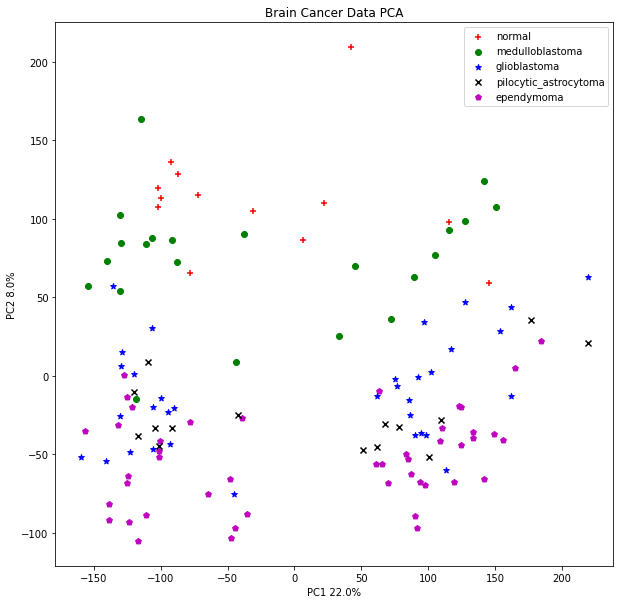

In [8]:
pca = PCA(n_components=2) 
pca.fit(scaled_data) 
xpca = pca.transform(scaled_data)

PC1 = 0 
PC2 = 1 

plt.figure(figsize=(10, 10))

for i in range(0, xpca.shape[0]):
  if 'normal' in y[i]: 
    c1 = plt.scatter(xpca[i,PC1],xpca[i,PC2], c='r', marker='+') 
  elif 'medulloblastoma' in y[i]: 
    c2 = plt.scatter(xpca[i,PC1],xpca[i,PC2], c='g', marker='o') 
  elif 'glioblastoma' in y[i]: 
    c3 = plt.scatter(xpca[i,PC1],xpca[i,PC2], c='b', marker='*') 
  elif 'pilocytic_astrocytoma' in y[i]:
    c4 = plt.scatter(xpca[i,PC1],xpca[i,PC2], c='k', marker='x') 
  elif 'ependymoma' in y[i]:
    c5 = plt.scatter(xpca[i,PC1],xpca[i,PC2], c='m', marker='p') 

# Add labels to PCA scatterplot:
plt.legend([c1, c2, c3, c4, c5],['normal', 'medulloblastoma', 'glioblastoma', 'pilocytic_astrocytoma', 'ependymoma']) 
plt.xlabel(f'PC1 {round(pca.explained_variance_ratio_[0],2)*100}%') 
plt.ylabel(f'PC2 {round(pca.explained_variance_ratio_[1],2)*100}%') 
plt.title('Brain Cancer Data PCA')
plt.show() 

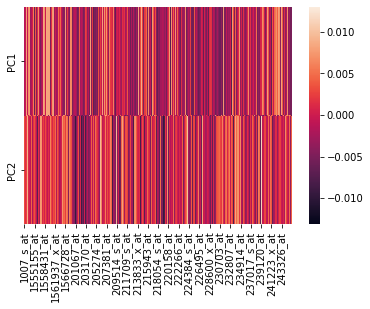

In [9]:
heat_df = pd.DataFrame(pca.components_, index=['PC1', 'PC2'], columns=data.columns[1:])
sns.heatmap(heat_df)

PCA with 2 components only explains 30% of the variance and doesn't show any clear groupings of the brain cancer subtypes.

In [10]:
def get_pca(data):
  pca = PCA(n_components=0.80)
  projected = pca.fit_transform(data)

  print(projected.shape)
  print(pca.explained_variance_ratio_)

In [11]:
get_pca(scaled_data)

(130, 40)
[0.22405245 0.07916083 0.07433943 0.05303791 0.04386578 0.03131864
 0.02519269 0.02239408 0.01895781 0.01736178 0.01546818 0.01482648
 0.0135113  0.01091089 0.00975621 0.00895159 0.008651   0.00798497
 0.00780947 0.00742534 0.00710677 0.00678092 0.00669438 0.00632131
 0.00615354 0.00606623 0.00582805 0.0057065  0.00555874 0.00533588
 0.00508694 0.00496687 0.00487167 0.00475668 0.00470676 0.00452396
 0.00444552 0.00435167 0.00418881 0.00417391]


To explain 80% of the variance, the PCA would need 40 components using the scaled data

In [12]:
# Create test and train datasets
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.30, random_state=1, stratify=y)

#print out test class proportion from total
display("Train data", collections.Counter(y_train))
display("Test data", collections.Counter(y_test))

'Train data'

Counter({'medulloblastoma': 15,
         'glioblastoma': 24,
         'ependymoma': 32,
         'pilocytic_astrocytoma': 11,
         'normal': 9})

'Test data'

Counter({'ependymoma': 14,
         'normal': 4,
         'medulloblastoma': 7,
         'glioblastoma': 10,
         'pilocytic_astrocytoma': 4})

## Lazy Predict Model
---

Use LazyPredict to visualize the performance of the top 5 classification models for the scaled data

100%|██████████| 29/29 [04:49<00:00,  9.98s/it]


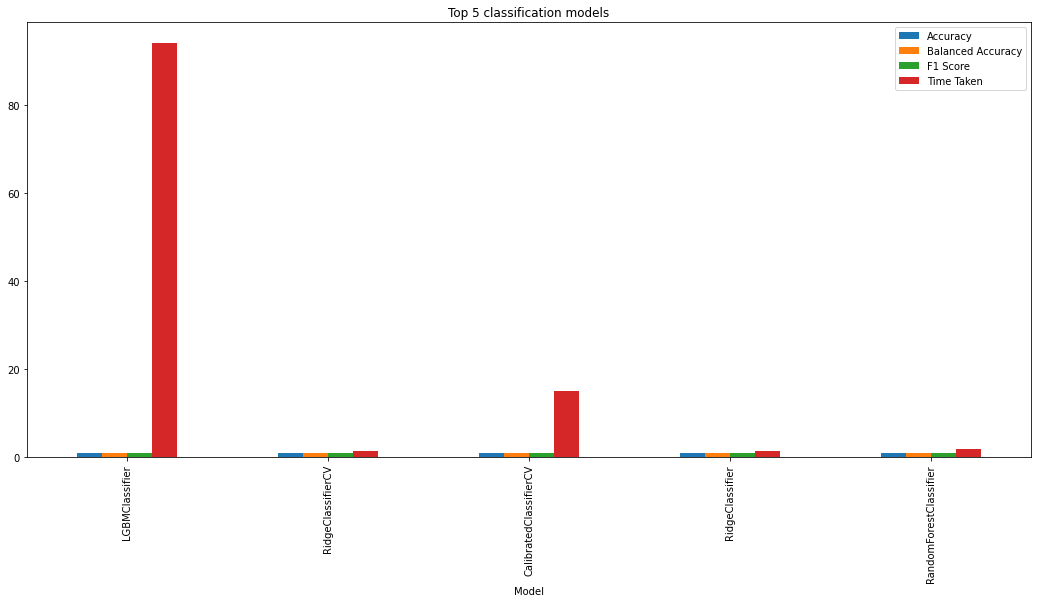

In [13]:
#Create a lazyClassifier model
model=LazyClassifier(verbose=0,predictions=True)

# fit and train the model 
start_time_1=time.time()
models_c,predictions_c=model.fit(X_train, X_test, y_train, y_test)
end_time_1=time.time()

models_c.iloc[0:5].plot.bar(figsize = (18,8), title="Top 5 classification models");

LazyPredict shows similar performance measured via F1 score across each of the top 5 classification models. However, Ridge Classifier and Random Forest take significantly less time than LGBM Classifier and Calibrated Classifier

## Random Forest Model
---

In [14]:
model = RandomForestClassifier(n_estimators=500, bootstrap=True)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
c_matrix = confusion_matrix(y_test,predictions)

CM_df = pd.DataFrame(c_matrix, columns=classes, index=classes)

cr = classification_report(y_test,predictions, output_dict=True)
model_accuracy = accuracy_score(y_test, predictions)

model_accuracy

0.9743589743589743

In [15]:
clsf_report = pd.DataFrame(cr).transpose()
clsf_report1 = clsf_report[0:n_classes]

fig = px.bar(clsf_report1, barmode='group', template=template)
fig.update_layout(width=700, height=700, template=template, title="Classification Report")
fig.show()

In [16]:
heat = go.Heatmap(z = c_matrix, x=CM_df.index, 
                  y=CM_df.columns, 
                  showscale = False,
                  text=CM_df,
                  texttemplate="%{text}",
                  textfont={"size":10})
fig = go.Figure(heat)
fig.update_layout(width=700, height=700, template=template, title="Confusion Matrix")
fig.show()

Despite the low variance explained in the PCA with 2 components, the random forest model predicted the test data with a 97.4% accuracy. The confusion matrix shows that the only type of brain cancer that did not yield 100% prediction accuracy was pilocytic astrocytoma which is not surprsing because this was the subtype with the fewest samples in the test split.

### Significant Features
---

In [17]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=features)

RF_df = pd.DataFrame(forest_importances.sort_values(ascending=False))
RF_df.columns = ['Feature']

#plot feature significance
fig = px.bar(RF_df[0:10], template=template)
fig.update_layout(width=1000, height=700, template=template, title="Top 10 Features by Significance")
fig.show()

The above plot shows the top 10 features of significance as determined by the RF model

In [18]:
estimator = model.estimators_[5]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = features,
                class_names = classes,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])


Image(filename = 'tree.png')

Example of decision tree used in random forest to classify the brain cancer subtypes. This tree shows that the first decision relies on the 219252_s_at feature to separate ependymomas.

## Autoencoder (Neural Network)
---

Because of the poor variance explained using the scaled data, explore dimensionality reduction using Autoencoder

In [19]:
def create_autoencoder(num_dimensions, optimizer, num_epochs):
  # USING FUNCTIONAL API MODEL
  ncol = X_train.shape[1]
  input_dim = Input(shape = (ncol, ))

  encoding_dim = num_dimensions #this can be changed if you want to create more features

  # Encoder Layers
  encoded = Dense(500, activation = 'relu')(input_dim)
  encoded = Dropout(0.5)(encoded) #DROUPOUT
  encoded = Dense(100, activation = 'relu')(encoded)
  encoded = Dense(encoding_dim, activation = 'relu')(encoded) # BOTTLENECK LAYER

  # Decoder Layers
  decoded = Dense(100, activation = 'relu')(encoded)
  decoded = Dense(250, activation = 'relu')(decoded)
  decoded = Dense(500, activation = 'relu')(decoded)
  decoded = Dense(ncol, activation = 'sigmoid')(decoded)

  # Combine Encoder and Deocder layers
  autoencoder = Model(inputs = input_dim, outputs = decoded)

  # Compile the Model
  autoencoder.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['mae'])
  autoencoder.fit(X_train, X_train, epochs = num_epochs,verbose=1, batch_size = 32, shuffle = False, validation_data = (X_test, X_test))
  encoder = Model(inputs = input_dim, outputs = encoded) #ASSIGN BOTTLENECK LAYER DATA AS OUTPUT
  encoded_input = Input(shape = (encoding_dim, ))

  # summarize history for accuracy
  plt.plot(autoencoder.history.history['mae'])
  plt.plot(autoencoder.history.history['val_mae'])
  plt.title(f'Mean Absolute Error {num_dimensions} Features')
  plt.ylabel('MAE')
  plt.xlabel('epoch cycles')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  return encoder

In [20]:
# create_autoencoder(50, 'adam', 50)

In [21]:
# create_autoencoder(100, 'adam', 50)

In [22]:
#create_autoencoder(50, 'adam', 100)

The models with different hyperparameters have comparable mean absolute errors so let's use 50 features and 50 epochs as the final model

Epoch 1/50
3/3 [==============================] - 3s 697ms/step - loss: 0.6150 - mae: 0.8912 - val_loss: -0.0877 - val_mae: 0.8006
Epoch 2/50
3/3 [==============================] - 2s 593ms/step - loss: -1.5717 - mae: 0.7811 - val_loss: -5.7879 - val_mae: 0.7792
Epoch 3/50
3/3 [==============================] - 2s 589ms/step - loss: -15.2921 - mae: 0.7716 - val_loss: -35.0618 - val_mae: 0.7907
Epoch 4/50
3/3 [==============================] - 2s 616ms/step - loss: -74.6515 - mae: 0.7762 - val_loss: -144.7668 - val_mae: 0.7860
Epoch 5/50
3/3 [==============================] - 2s 616ms/step - loss: -275.7903 - mae: 0.7769 - val_loss: -479.5956 - val_mae: 0.7902
Epoch 6/50
3/3 [==============================] - 2s 599ms/step - loss: -840.3767 - mae: 0.7788 - val_loss: -1396.9575 - val_mae: 0.7882
Epoch 7/50
3/3 [==============================] - 2s 603ms/step - loss: -2359.0264 - mae: 0.7809 - val_loss: -3679.2292 - val_mae: 0.7915
Epoch 8/50
3/3 [==============================] - 2s 605m

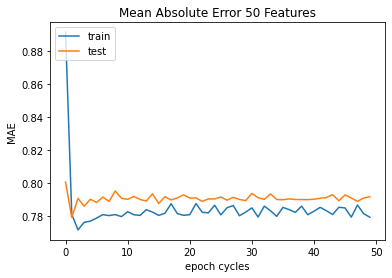

In [23]:
# Final Model
encoder = create_autoencoder(50, 'adam', 50)

In [24]:
# Prediction
encoded_train = pd.DataFrame(encoder.predict(X_train))
encoded_train = encoded_train.add_prefix('feature_')
encoded_test = pd.DataFrame(encoder.predict(X_test))
encoded_test = encoded_test.add_prefix('feature_')

encoded_train['id'] = y_train
encoded_train = encoded_train.set_index('id')

encoded_test['id'] = y_test
encoded_test = encoded_test.set_index('id')

X_encoded = pd.concat([encoded_train,encoded_test])
X_encoded.head()

2/2 [==============================] - 0s 33ms/step


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
id,,,,,,,,,,,,,,,,,,,,,
medulloblastoma,184.55,1635483.12,1324341.62,18046.96,929.19,1579695.50,1534827.25,1606704.50,1500780.12,1561084.62,...,110438.82,40983.57,1628348.50,1502689.12,1363424.00,1398720.00,1429005.38,0.00,811892.12,692.31
glioblastoma,3935729.75,0.00,4306361.00,4017387.00,4390770.00,0.00,0.00,0.00,0.00,0.00,...,3842716.25,3529665.75,0.00,0.00,4352165.50,4054525.75,3891604.00,0.00,4160615.25,4276899.00
ependymoma,0.00,4112084.25,3328391.00,44168.20,295.72,3971710.75,3858551.75,4039609.25,3773057.00,3924885.75,...,276348.59,101776.99,4093670.25,3778000.00,3427286.50,3516175.25,3591923.00,0.00,2039797.75,432.31
medulloblastoma,6463089.00,0.00,7071437.50,6597581.50,7210694.50,0.00,0.00,0.00,0.00,0.00,...,6310350.00,5796377.50,0.00,0.00,7146760.00,6658185.50,6390360.50,0.00,6831853.50,7023799.00
ependymoma,157.26,4973565.50,4027079.00,54968.78,2428.26,4803913.00,4667319.50,4885708.50,4563674.00,4747237.50,...,335826.16,124425.43,4951430.00,4569440.50,4146181.00,4252797.00,4345146.00,0.00,2468394.25,2067.35


### PCA
---

In [25]:
get_pca(X_encoded)

(130, 1)
[0.8167379]


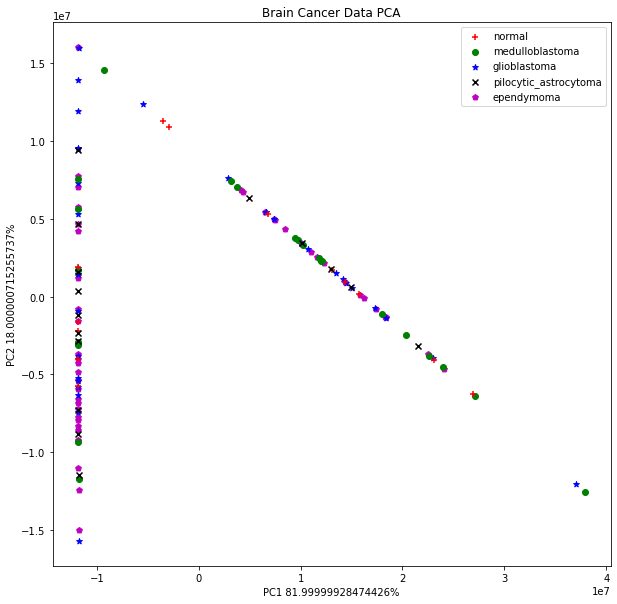

In [34]:
pca = PCA(n_components=2) 
pca.fit(X_encoded) 
xpca = pca.transform(X_encoded)

PC1 = 0 
PC2 = 1 

plt.figure(figsize=(10, 10))

for i in range(0, xpca.shape[0]):
  if 'normal' in y[i]: 
    c1 = plt.scatter(xpca[i,PC1],xpca[i,PC2], c='r', marker='+') 
  elif 'medulloblastoma' in y[i]: 
    c2 = plt.scatter(xpca[i,PC1],xpca[i,PC2], c='g', marker='o') 
  elif 'glioblastoma' in y[i]: 
    c3 = plt.scatter(xpca[i,PC1],xpca[i,PC2], c='b', marker='*') 
  elif 'pilocytic_astrocytoma' in y[i]:
    c4 = plt.scatter(xpca[i,PC1],xpca[i,PC2], c='k', marker='x') 
  elif 'ependymoma' in y[i]:
    c5 = plt.scatter(xpca[i,PC1],xpca[i,PC2], c='m', marker='p') 

# Add labels to PCA scatterplot:
plt.legend([c1, c2, c3, c4, c5],['normal', 'medulloblastoma', 'glioblastoma', 'pilocytic_astrocytoma', 'ependymoma']) 
plt.xlabel(f'PC1 {round(pca.explained_variance_ratio_[0],2)*100}%') 
plt.ylabel(f'PC2 {round(pca.explained_variance_ratio_[1],2)*100}%') 
plt.title('Brain Cancer Data PCA')
plt.show() 

100% of the variance in the encoded data is explained by a single component, however there is still no distinguishable groups in this encoded data set. There is no clear separation between the groups so let's explore feature selection for each cancer subtype and see if there is overlap between any.

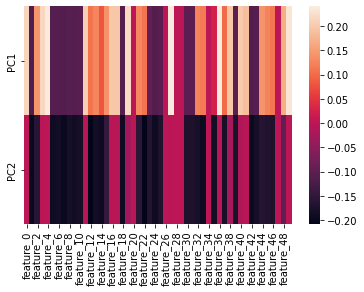

In [36]:
autoencoder_df = pd.DataFrame(pca.components_, index=['PC1', 'PC2'], columns=X_encoded.columns)
sns.heatmap(autoencoder_df)

## Brain Cancer Subtype Discovery
---

In [27]:
epend_df = data.loc[data['type'] == 'ependymoma']
pa_df = data.loc[data['type'] == 'pilocytic_astrocytoma']
med_df = data.loc[data['type'] == 'medulloblastoma']
glio_df = data.loc[data['type'] == 'glioblastoma']
normal_df = data.loc[data['type'] == 'normal']
cancer_df = data.loc[data['type'] != 'normal']
cancer_df['type'] = np.where(cancer_df['type'] != 'normal', 'Cancer', 'normal')

epend = pd.concat([epend_df, normal_df])
pa = pd.concat([pa_df, normal_df])
med = pd.concat([med_df, normal_df])
glio = pd.concat([glio_df, normal_df])
norm = pd.concat([cancer_df, normal_df])

In [28]:
def rf_classify_data(data):
  X = data.iloc[:, 1:].values
  y = data.iloc[:, 0].values

  features = data.columns[1:]

  classes = np.unique(y)
  n_classes = len(classes)

  print(data.type.value_counts())

  # Create test and train datasets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

  #print out test class proportion from total
  display("Train data", collections.Counter(y_train))
  display("Test data", collections.Counter(y_test))

  model = RandomForestClassifier(n_estimators=500, bootstrap=True)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)
  c_matrix = confusion_matrix(y_test,predictions)

  CM_df = pd.DataFrame(c_matrix, columns=classes, index=classes)

  cr = classification_report(y_test,predictions, output_dict=True)
  model_accuracy = accuracy_score(y_test, predictions)

  print(model_accuracy)

  clsf_report = pd.DataFrame(cr).transpose()
  clsf_report1 = clsf_report[0:n_classes]

  fig = px.bar(clsf_report1, barmode='group', template=template)
  fig.update_layout(width=700, height=700, template=template, title="Classification Report")
  fig.show()

  heat = go.Heatmap(z = c_matrix, x=CM_df.index, 
                    y=CM_df.columns, 
                    showscale = False,
                    text=CM_df,
                    texttemplate="%{text}",
                    textfont={"size":10})
  fig = go.Figure(heat)
  fig.update_layout(width=700, height=700, template=template, title="Confusion Matrix")
  fig.show()

  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
  forest_importances = pd.Series(importances, index=features)

  RF_df = pd.DataFrame(forest_importances.sort_values(ascending=False))
  RF_df.columns = ['Feature']

  #plot feature significance
  fig = px.bar(RF_df[0:10], template=template)
  fig.update_layout(width=1000, height=700, template=template, title="Top 10 Features by Significance")
  fig.show()

In [29]:
data_sets = [epend, pa, med, glio, norm]

for d in data_sets:
  rf_classify_data(d)

ependymoma    46
normal        13
Name: type, dtype: int64


'Train data'

Counter({'normal': 9, 'ependymoma': 32})

'Test data'

Counter({'ependymoma': 14, 'normal': 4})

1.0


pilocytic_astrocytoma    15
normal                   13
Name: type, dtype: int64


'Train data'

Counter({'normal': 9, 'pilocytic_astrocytoma': 10})

'Test data'

Counter({'pilocytic_astrocytoma': 5, 'normal': 4})

1.0


medulloblastoma    22
normal             13
Name: type, dtype: int64


'Train data'

Counter({'medulloblastoma': 15, 'normal': 9})

'Test data'

Counter({'medulloblastoma': 7, 'normal': 4})

1.0


glioblastoma    34
normal          13
Name: type, dtype: int64


'Train data'

Counter({'glioblastoma': 23, 'normal': 9})

'Test data'

Counter({'normal': 4, 'glioblastoma': 11})

1.0


Cancer    117
normal     13
Name: type, dtype: int64


'Train data'

Counter({'Cancer': 82, 'normal': 9})

'Test data'

Counter({'normal': 4, 'Cancer': 35})

0.9743589743589743


All four data sets yielded a 100% accuracy when comparing the cancer type to the normal control. The top 3 features for the ependymoma data set were found to be 205691_at, 206223_at, and 204077_x_at. For pilocytic astrocytoma they were 204729_s_at, 230019_s_at, and 210540_s_at. Medulloblastoma had 233049_x_at, 227228_s_at, and 208149_x_at. Finally, glioblastoma had 216228_s_at, 1564207_at, and 236249_at. Interestingly, there is no overlap in top three significant features amongst these brain cancer subtypes and there is no clear separation on the PCA. Despite this, the random forest classifier can successfullly distinguish each subtype from one another


* Ependymoma
  * [205691_at](http://biogps.org/#goto=genereport&id=9143) predominantly expressed in amygdala
  * [206223_at](http://biogps.org/#goto=genereport&id=22853) predominantly expressed in lymphoma
  * [204077_x_at](http://biogps.org/#goto=genereport&id=9583) predominantly expresed in CD8 cells

* Pilocytic Astrocytoma
  * [204729_s_at](http://biogps.org/#goto=genereport&id=6804) predominantly expressed in the whole brain
  * [230019_s_at](http://biogps.org/#goto=genereport&id=57540) predominantly expressed in the lungs
  * [210540_s_at](http://biogps.org/#goto=genereport&id=8702) predominantly expressed in skeletal muscle

* Medulloblastoma
  * [233049_x_at](http://biogps.org/#goto=genereport&id=10273) predominantly expressed in the whole brain
  * [227228_s_at](http://biogps.org/#goto=genereport&id=440193) predominantly expressed in CD56 cells
  * [208149_x_at](http://biogps.org/#goto=genereport&id=1663) predominantly expressed in leukemialymphoblastic

* Glioblastoma
  * [216228_s_at](http://biogps.org/#goto=genereport&id=11169) predominantly expressed in smooth muscle
  * [1564207_at](http://biogps.org/#goto=genereport&id=255031) does not currently have data available
  * [236249_at](http://biogps.org/#goto=genereport&id=121457) predominantly expressed in smooth muscle

* Combined (all cancer subtype)
  * [209946_at](http://biogps.org/#goto=genereport&id=7424) predominantly expressed in bronchial epithelial cells
  * [220156_at](http://biogps.org/#goto=genereport&id=79645) predominantly expressed in lymphoma
  * [204783_at](http://biogps.org/#goto=genereport&id=4291) predominantly expressed in testis germ cells

* Cancer vs Normal
  * [213834_at](http://biogps.org/#goto=genereport&id=440073) predominantly expressed in cerebellum peduncles
  * [219186_at](http://biogps.org/#goto=genereport&id=51341) predominantly expressed in prefrontal cortex
  * [227937_at](http://biogps.org/#goto=genereport&id=339344) predominantly expressed in a range of locations including kidney, bone marrow, adrenal gland, thalamus, and parietal lobe


(130, 31)
[0.17462259 0.13197675 0.09359468 0.07667898 0.03447188 0.02851512
 0.0263976  0.02165195 0.02103677 0.02023249 0.01809328 0.01628861
 0.01263153 0.00999926 0.00982421 0.00932496 0.00882955 0.00780585
 0.00762946 0.00736045 0.00702997 0.0066537  0.00635037 0.00608697
 0.0060174  0.0058648  0.00562644 0.00552882 0.00530869 0.00512008
 0.0050086 ]


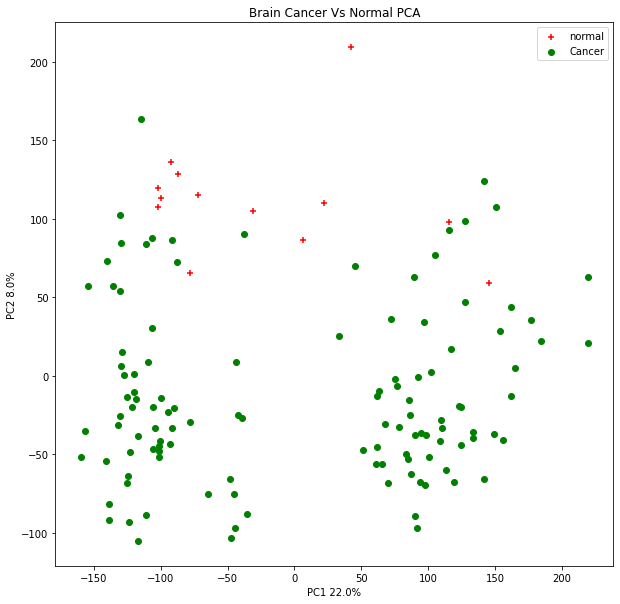

In [30]:
norm_X = norm.iloc[:, 1:].values
norm_y = norm.iloc[:, 0].values

scaled = StandardScaler() 
scaled.fit(norm_X) 
scaled_norm = scaled.transform(norm_X)

norm_classes = np.unique(norm_y)
n_classes = len(classes)

norm.type.value_counts()

get_pca(norm_X)

pca = PCA(n_components=2) 
pca.fit(scaled_norm) 
xpca = pca.transform(scaled_norm)

PC1 = 0 
PC2 = 1 

plt.figure(figsize=(10, 10))

for i in range(0, xpca.shape[0]):
  if 'normal' in norm_y[i]: 
    c1 = plt.scatter(xpca[i,PC1],xpca[i,PC2], c='r', marker='+') 
  elif 'Cancer' in norm_y[i]: 
    c2 = plt.scatter(xpca[i,PC1],xpca[i,PC2], c='g', marker='o')

# Add labels to PCA scatterplot:
plt.legend([c1, c2],['normal', 'Cancer']) 
plt.xlabel(f'PC1 {round(pca.explained_variance_ratio_[0],2)*100}%') 
plt.ylabel(f'PC2 {round(pca.explained_variance_ratio_[1],2)*100}%') 
plt.title('Brain Cancer Vs Normal PCA')
plt.show() 

In [37]:
#Run Principal Component Analysis
pca = PCA(n_components=3) 

pca.fit(scaled_norm) 
xpca = pca.transform(scaled_norm)

PC1_label = "PC1 {}%".format(round((100*pca.explained_variance_ratio_[0]),2))
PC2_label = "PC2 {}%".format(round((100*pca.explained_variance_ratio_[1]),2)) 
PC3_label = "PC3 {}%".format(round((100*pca.explained_variance_ratio_[2]),2))

#create dataframe for PCA
df_pca = pd.DataFrame(xpca)
df_pca.columns = [PC1_label,PC2_label,PC3_label]

#visualize
figPCA = px.scatter_3d(df_pca, x=PC1_label, y=PC2_label, z=PC3_label, 
                       title="PCA 3D plot, colored by Cancer vs control", color=norm_y,
                       template="plotly_white", height=800, width=800)
figPCA.show()

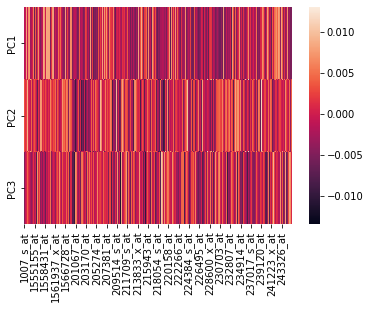

In [44]:
norm_heat_df = pd.DataFrame(pca.components_, index=['PC1', 'PC2', 'PC3'], columns=norm.columns[1:])
sns.heatmap(norm_heat_df)

# Discussion
---

Looking at all cancer vs control data in both 2 and 3 dimensional space does not yield any apparent natural separation between the groups and only 37.76% of the variance is explained in the 3-dimensional space. Despite this, the random forest model can classify cancer vs control with 97.4% accuracy, relying on features representing genes expressed both predominantly in the brain and in other organs.

Analyzing the top three features of significance for each cancer subtype vs the control, all cancer vs control, and the larger combined random forest model classifying each subtype and control did not identify any features or genes overlapping. For this reason, there is potential of identifying unique biomarkers representative of each brain cancer subtype. Furthermore, the [lab](https://sbcb.inf.ufrgs.br/cumida.html) responsible for curating the data used in this investigation reported a random forest model accuracy of 91% while 97.4% was achieved here.

The random forest model was selected for further exploration because of the results of the lazy predict model. It suggested the random forest model would be one of the more accurate classification models as well as one of the fastest. This evidence allowed for exploring this RF classification compared to the SBCB Lab findings.

The lab did not report any statistics on the results of applying an autoencoder to the data, however, the findings here showed a realtively high mean absolute error between both test and train data, suggesting the RF model was more effective. The neural network was efficient at consolidating the data so that a PCA plot explained 100% of the variance in a single component, however, this still did not result in clear distinguishable groups between the individual tumor subtypes.

The features found to be significant for each component of this analysis can be found below along with the corresponding genes.

* Ependymoma
  * [205691_at](http://biogps.org/#goto=genereport&id=9143) predominantly expressed in amygdala
    * SYNGR3 - membrane protein
  * [206223_at](http://biogps.org/#goto=genereport&id=22853) predominantly expressed in lymphoma
    * LMTK2 - enzyme
  * [204077_x_at](http://biogps.org/#goto=genereport&id=9583) predominantly expresed in CD8 cells
    * ENTPD4 - enzyme

* Pilocytic Astrocytoma
  * [204729_s_at](http://biogps.org/#goto=genereport&id=6804) predominantly expressed in the whole brain
    * STX1A - nervous system protein helping dock synaptic vesicles
  * [230019_s_at](http://biogps.org/#goto=genereport&id=57540) predominantly expressed in the lungs
    * DISP3 - smoothened signalling pathway
  * [210540_s_at](http://biogps.org/#goto=genereport&id=8702) predominantly expressed in skeletal muscle
    * B4GALT4 - enzyme

* Medulloblastoma
  * [233049_x_at](http://biogps.org/#goto=genereport&id=10273) predominantly expressed in the whole brain
    * STUB1 - inhibits ATPase
  * [227228_s_at](http://biogps.org/#goto=genereport&id=440193) predominantly expressed in CD56 cells
    * 	CCDC88C - negative regulator of wnt signalling pathway
  * [208149_x_at](http://biogps.org/#goto=genereport&id=1663) predominantly expressed in leukemialymphoblastic
    * DDX11 - enzyme

* Glioblastoma
  * [216228_s_at](http://biogps.org/#goto=genereport&id=11169) predominantly expressed in smooth muscle
    * WDHD1 - chromatin assembly
  * [1564207_at](http://biogps.org/#goto=genereport&id=255031) does not currently have data available
    * 	LINC00957
  * [236249_at](http://biogps.org/#goto=genereport&id=121457) predominantly expressed in smooth muscle
    * 	IKBIP

* Combined (all cancer subtype)
  * [209946_at](http://biogps.org/#goto=genereport&id=7424) predominantly expressed in bronchial epithelial cells
    * 	VEGFC - promote lymphatic vessel growth
  * [220156_at](http://biogps.org/#goto=genereport&id=79645) predominantly expressed in lymphoma
    * CLXN - calcium binding
  * [204783_at](http://biogps.org/#goto=genereport&id=4291) predominantly expressed in testis germ cells
    * 	MLF1 - DNA binding

* Cancer vs Normal
  * [213834_at](http://biogps.org/#goto=genereport&id=440073) predominantly expressed in cerebellum peduncles
    * 	IQSEC3 - actin cytoskeleton organization
  * [219186_at](http://biogps.org/#goto=genereport&id=51341) predominantly expressed in prefrontal cortex
    * ZBTB7A - DNA binding
  * [227937_at](http://biogps.org/#goto=genereport&id=339344) predominantly expressed in a range of locations including kidney, bone marrow, adrenal gland, thalamus, and parietal lobe
    * MYPOP - DNA binding


# References

---

* Feltes, B.C.; Chandelier, E.B.; Grisci, B.I.; Dorn, M. CuMiDa: An Extensively Curated Microarray Database for Benchmarking and Testing of Machine Learning Approaches in Cancer Research. Journal of Computational Biology, 2019.
* Griesinger AM, Birks DK, Donson AM, Amani V et al. Characterization of distinct immunophenotypes across pediatric brain tumor types. J Immunol 2013 Nov 1;191(9):4880-8. PMID: 24078694
* [GEO Data](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE50161)
* [Harvard Datverse Link](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/RILXEA)




In [33]:
import seaborn as sns